# Train object detection model with annotations and images from EXACT

## Imports 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [27]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from exact_sync.exact_enums import *
from exact_sync.exact_errors import *
from exact_sync.exact_manager import * 

In [3]:
import os
from pathlib import Path

## Train EXACT

### Set user name, password and server address

Load from file for production

In [101]:
username="Demo"
password="demodemo"
serverurl="https://exact.cs.fau.de/"
target_folder = Path('examples/images/') 

In [17]:
# Name of the data-sets to download images and annotations from
training_dataset_name = ['Icon Art Dataset']
os.makedirs(str(target_folder), exist_ok=True)

In [18]:
manager = ExactManager(username=username,   password=password, serverurl=serverurl)
temp = manager.retrieve_imagesets()

2020-02-23 17:30:21.150796 Time offset to server is: 0.42505669593811035 seconds.


In [24]:
dataset = [data for data in temp if data['name'] in training_dataset_name]
#len("Nr of found datasets: {}".format(len(dataset)))

23

### Download

In [118]:
images, lbl_bbox = [], []
for image_set in dataset:
    annotationtypes =  {anno_type['id']:anno_type for anno_type in manager.retrieve_annotationtypes(image_set['id'])}

    for image in tqdm(image_set['images']):
        coordinates, labels = [], []
        
        id = image['id']
        name = image['name']
        image_path = target_folder/name

        # if file not exists download it
        if image_path.is_file() == False:
            manager.download_image(id, image_path)

        for anno in manager.retrieve_annotations(id):
            coordinates.append([anno['vector']['y1'], anno['vector']['x1'], anno['vector']['y2'], anno['vector']['x2']])
            labels.append(anno['annotation_type']['name'])

        images.append(name)
        lbl_bbox.append([coordinates, labels])


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.86it/s]


In [104]:
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [105]:
print("Images: {} Annotations: {}".format(len(images), sum([len(annos[1]) for annos in lbl_bbox])))

Images: 25 Annotations: 372


In [116]:
images[0]

'Q3698227.jpg'

In [117]:
lbl_bbox[0]

[[[499, 38, 860, 176],
  [16, 80, 568, 529],
  [134, 489, 209, 600],
  [217, 393, 276, 482],
  [221, 139, 290, 238],
  [127, 13, 202, 126],
  [18, 123, 68, 211],
  [17, 391, 69, 490]],
 ['Mary',
  'crucifixion_of_Jesus',
  'angel',
  'angel',
  'angel',
  'angel',
  'angel',
  'angel']]

### Create fastai data object

In [7]:
from helper.object_detection_helper import *
from loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from models.RetinaNet import RetinaNet
from callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.0.0
torch cuda    : 10.0 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : Quadro P5200

=== Environment === 
platform      : Windows-10-10.0.17763-SP0
conda env     : fastai
python        : D:\Programme\Anaconda\envs\fastai\python.exe
sys.path      : D:\Programme\Anaconda\envs\fastai\python36.zip
D:\Programme\Anaconda\envs\fastai\DLLs
D:\Programme\Anaconda\envs\fastai\lib
D:\Programme\Anaconda\envs\fastai

D:\Programme\Anaconda\envs\fastai\lib\site-packages
D:\ProgProjekte\Python\tensorflow\cocoapi\PythonAPI\pycocotools
D:\ProgProjekte\Python\fastai\fastai
D:\ProgProjekte\Python\Promotion\ObjectDetection
D:\ProgProjekte\Python\Object-Detection-Metrics\lib
D:\ProgProjekte\Python\SlideRunner
D:\ProgProjekte\Python\Promotion\EXACT-Sync
D:\Programme\Anaconda\envs\fastai\lib\site-packages\win32
D:\Programme\Anaconda\envs\fastai

### Import or install object detection lib

#### Import error

If import fails clone both repos and add them to sys path:
1. https://github.com/ChristianMarzahl/ObjectDetection
2. https://github.com/rafaelpadilla/Object-Detection-Metrics

```python
import sys
sys.path.append("Object-Detection-Metrics/lib")
sys.path.append("ObjectDetection")
```

In [106]:
size = 256
bs = 4

In [107]:
data = (ObjectItemList.from_folder(target_folder)
        #Where are the images? 
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=0))

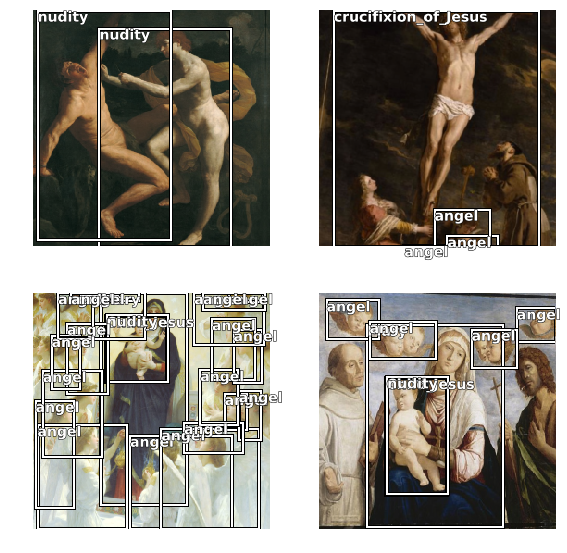

In [108]:
data.show_batch()

In [109]:
data.train_ds.classes

['background',
 'Child_Jesus',
 'Mary',
 'Saint_Sebastien',
 'angel',
 'crucifixion_of_Jesus',
 'nudity']

### Train data-set 

In [110]:
anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 0.6, 1, 1.25, 1.6])

In [111]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=18, sizes=[32,16,8,4], chs=128, final_bias=-4., n_conv=3)

In [112]:
voc = PascalVOCMetric(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [113]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 2.51E-04


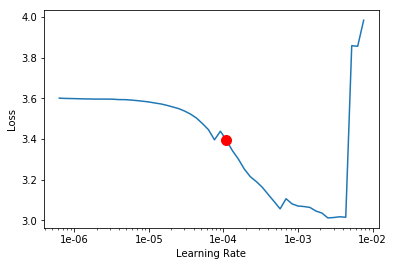

In [114]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-Child_Jesus,AP-Mary,AP-Saint_Sebastien,AP-angel,AP-crucifixion_of_Jesus,AP-nudity,time
0,3.405754,3.135669,0,0.658405,2.477264,0,0,0,0,0,0,00:02


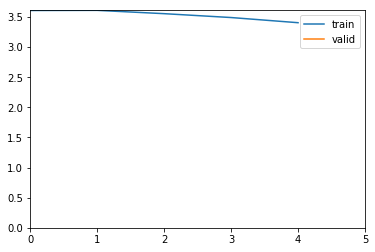

In [115]:
learn.fit_one_cycle(1, 1e-4)